# Imports

In [1]:
import os

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import cv2

from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

# Data

In [2]:
class SouthParkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.paths = []
        for dir, subdir, files in os.walk(self.root_dir):
            for file in files:
                self.paths.append(os.path.join(dir, file))

    @staticmethod
    def __read_img(path) -> torch.Tensor:
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        return image
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = self.__read_img(self.paths[idx])

        if self.transform:
            image = self.transform(image)

        return image

In [3]:
dataset = SouthParkDataset(root_dir="single_character_data", transform=None)
len(dataset)

906

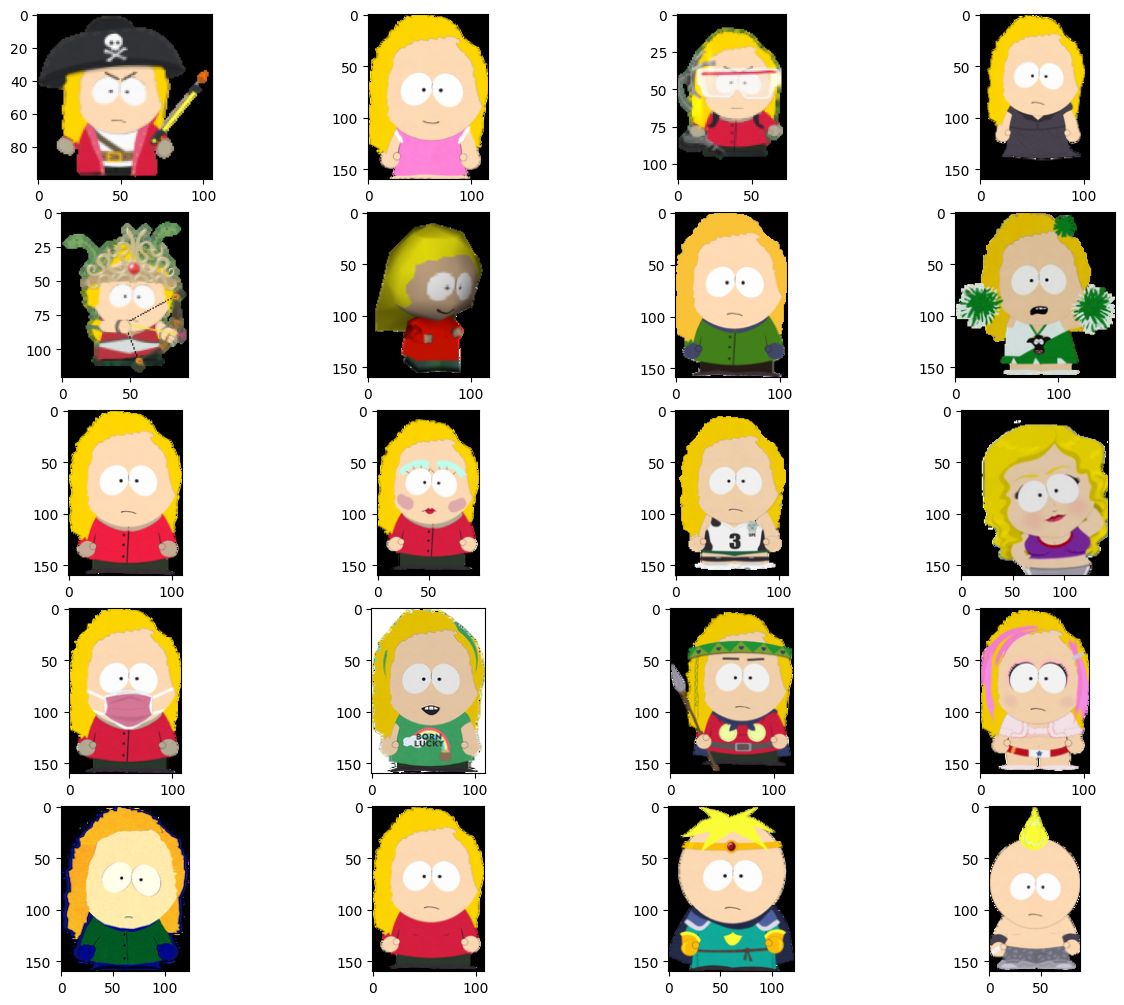

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt


def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)



show_images(dataset)

# Transforms

In [5]:
IMG_SIZE = 32
BATCH_SIZE = 128


def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ])

    dataset = SouthParkDataset(root_dir="single_character_data", transform=data_transforms)
    
    return dataset


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0]
        
    plt.imshow(reverse_transforms(image))

    
train_dataset = load_transformed_dataset()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


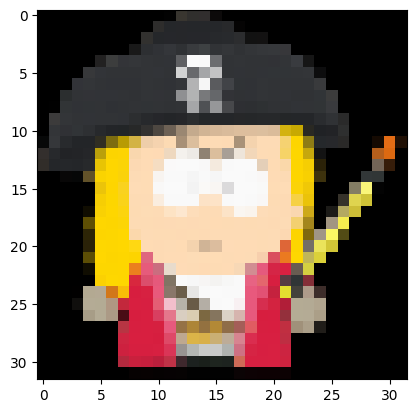

In [6]:
show_tensor_image(train_dataset[0])

# Model

In [10]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim

        self.encoder =  nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.flatten = nn.Flatten()

        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        z = self.flatten(self.encoder(x))
        return z
        
    def decode(self, z):
        z = z.reshape((z.shape[0], self.z_dim, 2, 2))
        x_rec = self.decoder(z)
        return x_rec

    def forward(self, x):
        z = self.encode(x).reshape((x.shape[0], self.z_dim, 2, 2))
        x_rec = self.decode(z)

        return x_rec

# Loops

In [11]:
def train_epoch(model, dataloader, device):
    model.to(device)
    model.train()

    total_loss = 0.0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        images = batch.to(device)
        rec_images = model(images)
        
        loss = F.mse_loss(rec_images, images)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader.dataset)

# Training

In [12]:
from torch.optim import Adam
from tqdm.auto import tqdm

model = VAE(z_dim=64)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 100 # Try more!

for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, device)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]


Epoch 0 | Train Loss: 0.006710811627095372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.72it/s]


Epoch 10 | Train Loss: 0.0040818587044216936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.62it/s]


Epoch 20 | Train Loss: 0.003663190317732872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.03it/s]


Epoch 30 | Train Loss: 0.0034790255507622858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.28it/s]


Epoch 40 | Train Loss: 0.003367005397152427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.17it/s]


Epoch 50 | Train Loss: 0.003289130415611183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.30it/s]


Epoch 60 | Train Loss: 0.003237897197142342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.59it/s]


Epoch 70 | Train Loss: 0.0031975213660309647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.64it/s]


Epoch 80 | Train Loss: 0.003160986185863318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.33it/s]


Epoch 90 | Train Loss: 0.0031433851184697603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.70it/s]


# Sample

## Example of reconstruction

In [15]:
model.eval()
with torch.no_grad():
    rec_images = model(train_dataset[400].unsqueeze(0).cuda())

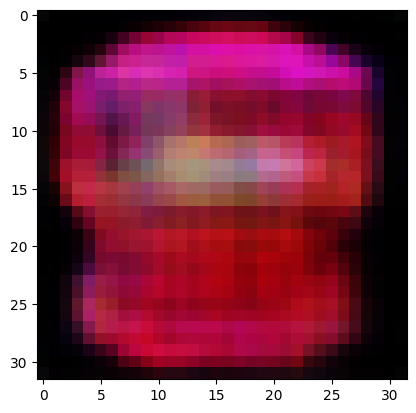

In [16]:
plt.imshow(rec_images[0].permute(1, 2, 0).cpu().numpy())

# Lest compute the mean embedding and generate from it

In [21]:
embeddings = []

model.eval()
for i in range(len(train_dataset)):
    with torch.no_grad():
        rec_images = model.encode(train_dataset[i].unsqueeze(0).cuda())

    embeddings.append(rec_images)

In [26]:
mean_embedding = sum(embeddings) / len(embeddings)
mean_embedding.shape

torch.Size([1, 256])

In [25]:
plt.imshow(mean_embedding[0].permute(1, 2, 0).cpu().numpy())

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 3